# Stats Modelling

Taking the stats df generated from combined_analysis.ipynb

In [1]:
import os
import pprint
import tqdm
import json
import glob
import jsonlines
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import textwrap

import sys
from collections import Counter
import datetime
import h5py
import seaborn as sns
from typing import NamedTuple
import re
import statsmodels.api as sm
from collections import defaultdict
from operator import attrgetter
import statsmodels.formula.api as smf
from pandas.plotting import scatter_matrix

#load in search hashtags
with open('../references/search_hashtags.txt', 'r') as f:
    search_hashtags = f.readlines()
    search_hashtags = [i.replace('\n', '') for i in search_hashtags]
    search_hashtags = [i.replace('#', '') for i in search_hashtags]
    search_hashtags = [i.lower() for i in search_hashtags]
    search_hashtags.remove('وأناكمان')

# Define Functions for analysis

In [2]:
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

def normalise(df):
    stats_df_normalised = df.copy()
    for col in ['int_pre_peak',
        'act_pre_peak',
        'act_pre_peak_avg',
        'act_post_peak',
        'act_post_peak_avg',
        'norm_act_pre_peak',
        'norm_act_pre_peak_avg',
        'act_pre_peak_avg',
        'likes_std',
        'interval_minutes']:

        stats_df_normalised[col] = min_max_scaling(df[col])

    stats_df_normalised = stats_df_normalised[~stats_df_normalised['interval_minutes'].isnull()]
    stats_df_normalised['interval_minutes'] = 1-stats_df_normalised['interval_minutes']

    return stats_df_normalised

In [3]:
def scatter_vis(df, target = 'act_post_peak', group_num = 1, kind = 'sns'):

    plt.figure(figsize = (15,8))

    if kind == 'sns':

        g=sns.pairplot(df[[
            'Interaction Count Before Network Peak',
            'Non-protest Activity Before Peak',
            'Count of Experimentation Successes',
            'Reciprocal Count',
            'Percentage Reciprocal',
            target
        ]])
        for ax in g.axes.flatten():
            # rotate x axis labels
            ax.set_xlabel(ax.get_xlabel(), rotation = 30)
            # set x labels alignment
            ax.xaxis.get_label().set_horizontalalignment('right')
            # rotate y axis labels
            ax.set_ylabel(ax.get_ylabel(), rotation = 0)
            # set y labels alignment
            ax.yaxis.get_label().set_horizontalalignment('right')

    else:
        x = scatter_matrix(df[['int_pre_peak',
        'act_pre_peak',
        'norm_act_pre_peak',
        'likes_std',
        'reciprocal',
        'weight',
        'percent_reciprocal',
        target]],figsize=(20,15));

    plt.savefig(f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/results/0{group_num}_group/scatter_{target}.png')

def read_in_data(group_num):
    save_filename = f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/06_reporting/stats_df_group_{group_num}.obj'
    with open(save_filename, 'rb') as f:
        stats_df = pickle.load(f)
    return stats_df

In [4]:
def model_selection(data, response, family=sm.families.family.NegativeBinomial(alpha=2), forward=True, subset_ht = None):
    '''Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    '''

    remaining = set(data.columns)
    remaining.remove(response)
    if subset_ht:
        data = data[data['ht']==subset_ht]
        data = data.drop(['ht'],axis=1)
        remaining.remove('ht')
    if forward:
        selected = []
    else:
        # for backward selection, start with the full set.
        selected = remaining.copy()
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            if forward:
                formula = "{} ~ {} + 1".format(response,
                                            ' + '.join(selected + [candidate]))
            else:
                formula = "{} ~ {} + 1".format(response,
                                            ' + '.join([i for i in selected if i!=candidate]))
            try:
                score = smf.glm(formula, data, family=family).fit().aic
            except ValueError:
                continue
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            if forward:
                remaining.remove(best_candidate)
                selected.append(best_candidate)
                current_score = best_new_score
            else:
                remaining.remove(best_candidate)
                selected.remove(best_candidate)
                current_score = best_new_score
        else:
            break
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.glm(formula, data, family=family).fit()
    return model

def write_to_latex(summary, group_num, dep_var, forward=True):
    results_folder = f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/results/0{group_num}_group'
    write_string = summary.as_latex()
    if forward:
        forward_str='forward'
    else:
        forward_str='backward'
    res_file = os.path.join(results_folder, f'table_{dep_var}_{forward_str}.tex')

    with open(res_file, 'w') as f:
        f.writelines(write_string)

# Group 1: 2017-11-16 to 2018-05-29

In [5]:
group_num = 3
hashtag_split = True
ngram_range = '34'
min_user = 100

overwrite = True
read_in = True

df = read_in_data(group_num)
# df = normalise(df)

In [6]:
# rename columns:

df.columns

Index(['author_id', 'int_pre_peak', 'act_pre_peak', 'norm_act_pre_peak',
       'act_pre_peak_avg', 'norm_act_pre_peak_avg', 'act_post_peak',
       'act_post_peak_avg', 'ht', 'likes_std', 'org', 'age', 'gender', 'lang',
       'hashtag_lang', 'lang_diff', 'interval', 'interval_minutes',
       'same_cluster_change', 'weight', 'reciprocal', 'percent_reciprocal'],
      dtype='object')

In [14]:
df.columns = ['User ID', 'Interaction Count Before Network Peak', 'Protest Activity Before Network Peak', 'Average Protest Activity Before Peak',
       'Non-protest Activity Before Peak', 'Average Non-protest Activity Before Peak', 'Protest Activity Post Peak', 'Average Protest Activity Post Peak', 'Primary Protest Network', 'Count of Experimentation Successes', 'Is an Organisation', 'Age', 'Gender', 'Language',
       'Hashtag Language', 'Language Difference', 'Interval', 'Interval (minutes)',
       'Cluster Change', 'Weight', 'Reciprocal Count', 'Percentage Reciprocal']

## Research Question 1

<Figure size 1080x576 with 0 Axes>

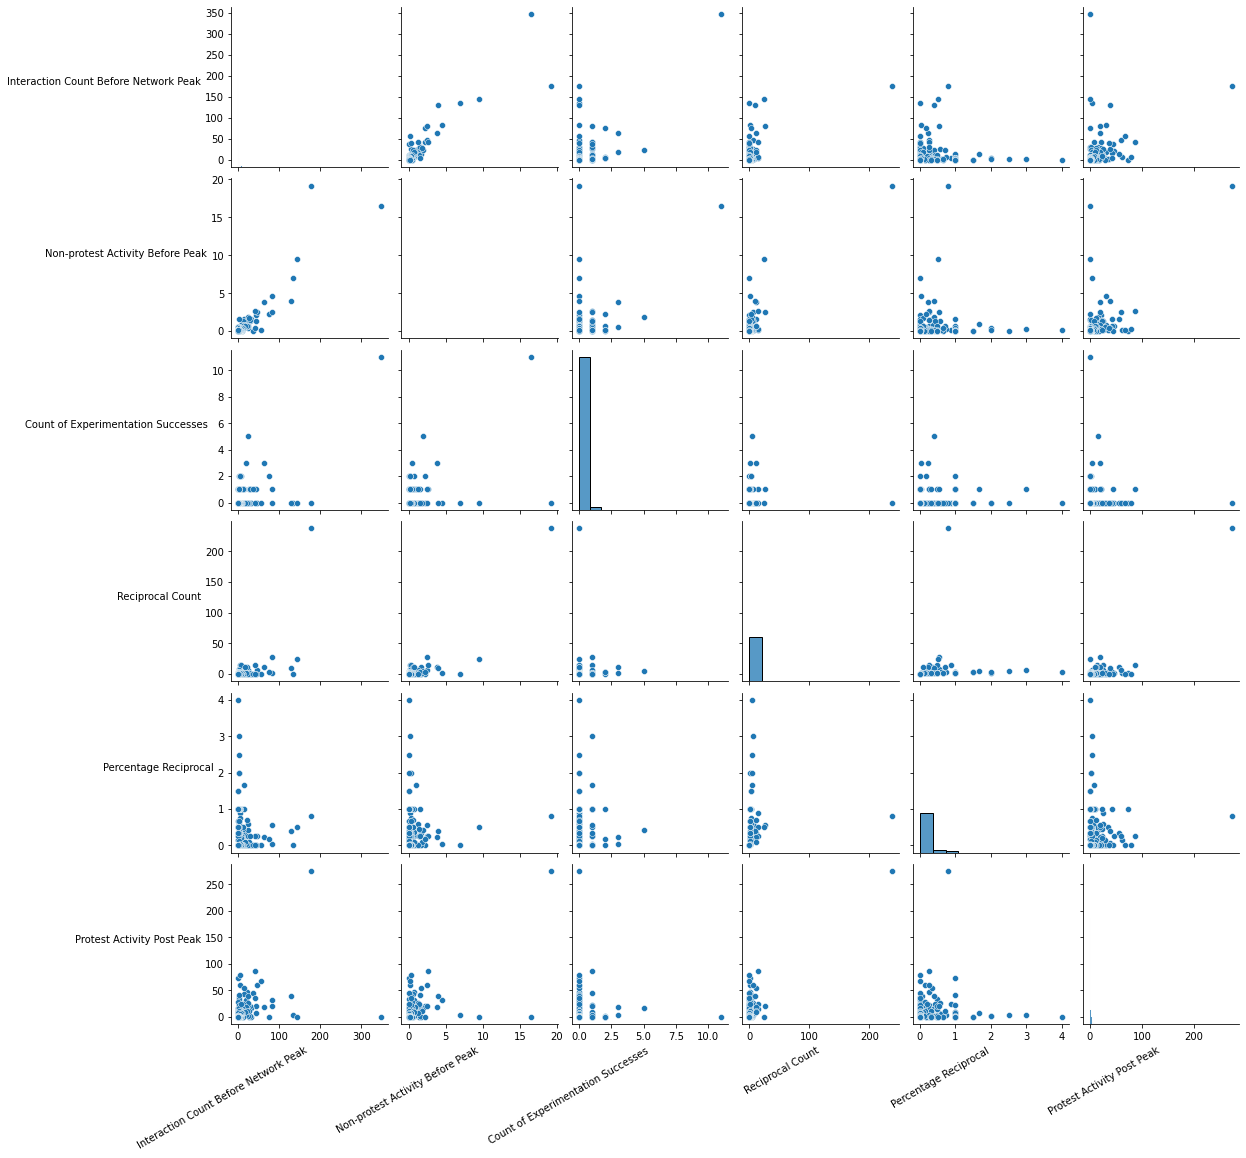

In [15]:
scatter_vis(df, target = 'Protest Activity Post Peak', group_num=group_num)

<Figure size 1080x576 with 0 Axes>

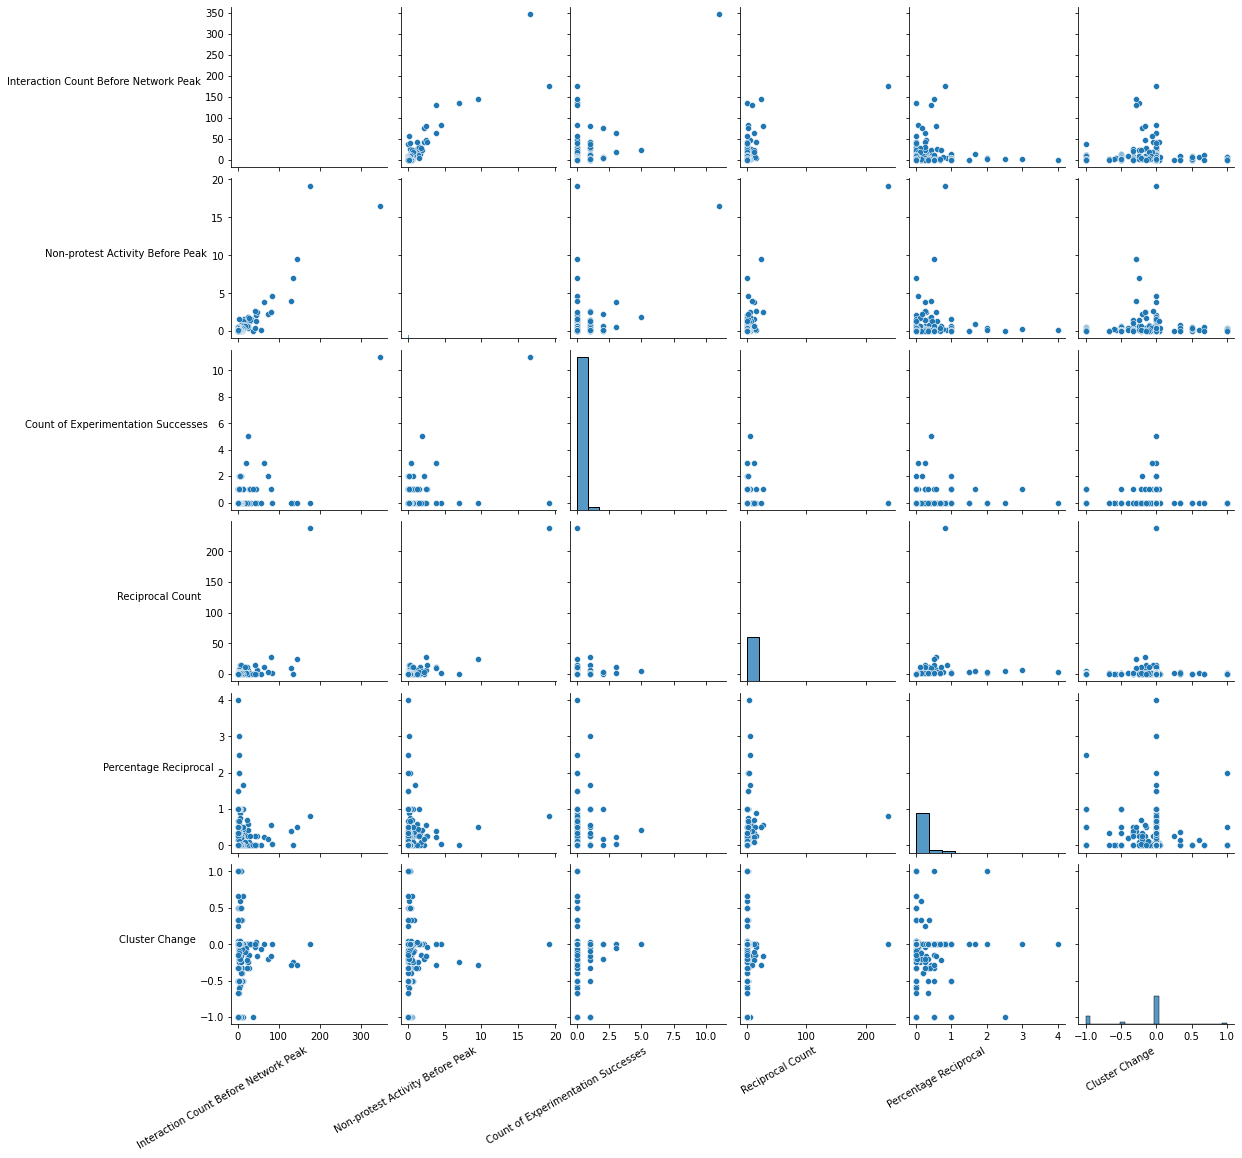

In [16]:
scatter_vis(df, target = 'Cluster Change', group_num=group_num)

<Figure size 1080x576 with 0 Axes>

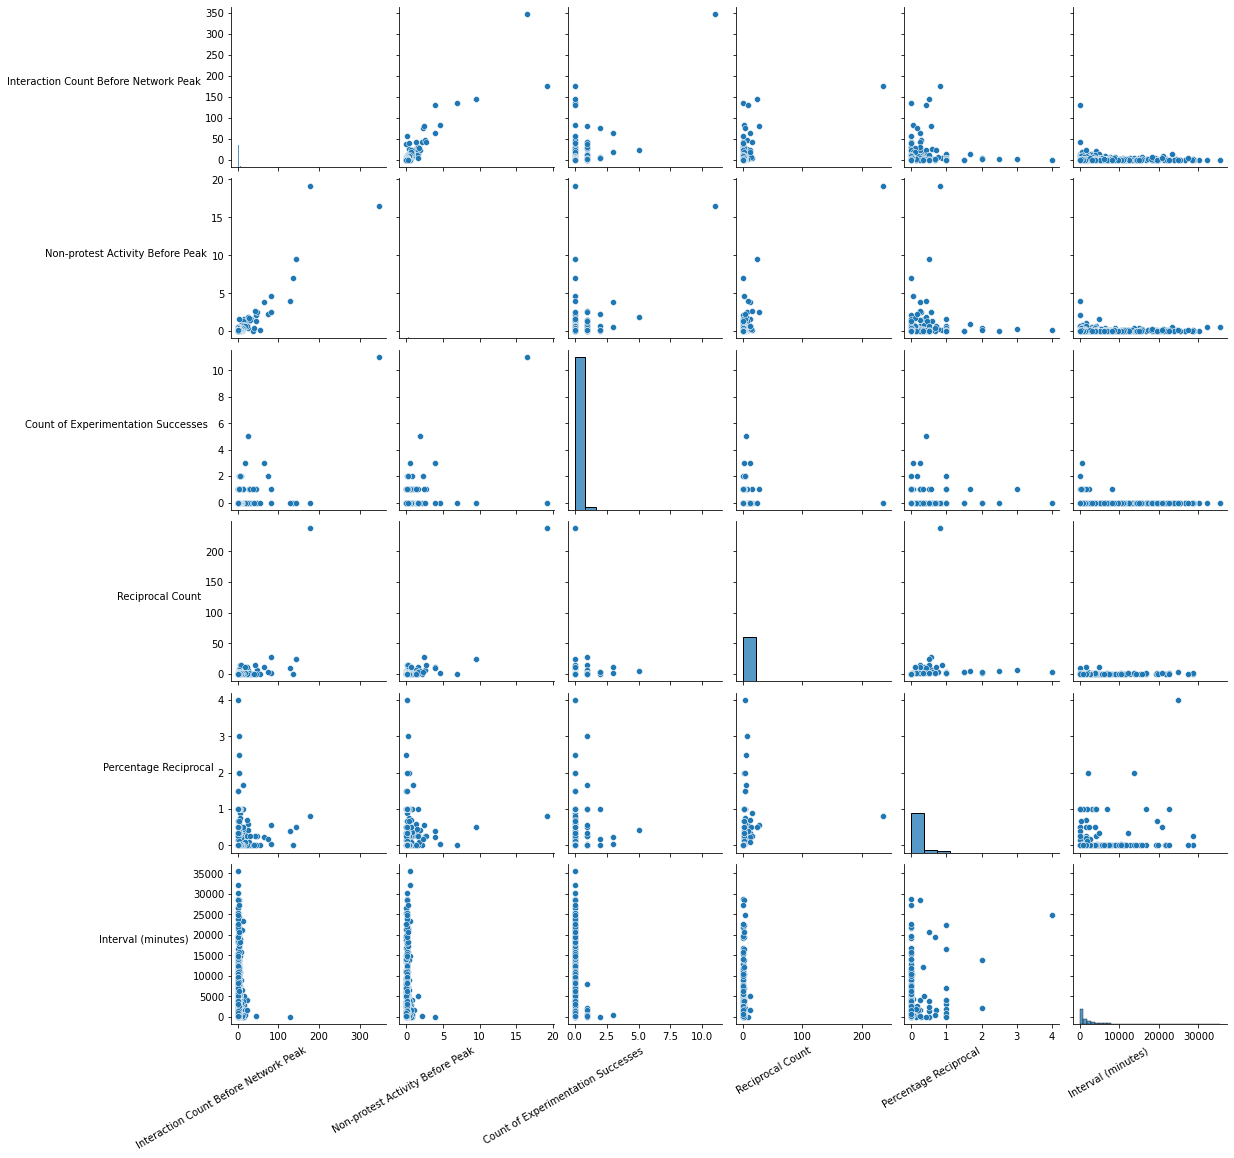

In [17]:
scatter_vis(df, target = 'Interval (minutes)', group_num=group_num)

In [ ]:
# foward selection for cluster change:
best_forward_model = model_selection(
    df.drop(['interval','author_id','act_post_peak','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak'], axis=1),
    'same_cluster_change',
    sm.families.family.Gaussian()
)

# foward selection for cluster change:
best_backward_model = model_selection(
    df.drop(['interval','author_id','act_post_peak','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak'], axis=1),
    'same_cluster_change',
    sm.families.family.Gaussian(),
    forward=False
)

In [ ]:
best_forward_model.summary()
write_to_latex(best_forward_model.summary(), group_num, 'same_cluster_change', forward=True)

best_backward_model.summary()
write_to_latex(best_backward_model.summary(), group_num, 'same_cluster_change', forward=False)

In [18]:
# foward selection for act post peak:
temp = df.drop(['interval','author_id','same_cluster_change','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg', 'org', 'age', 'gender'] , axis=1)
temp.rename(columns={'act_post_peak': 'Activity', 'norm_act_pre_peak_avg': 'Average_Activity_Before_Peak'}, inplace=True)
best_forward_model_act = model_selection(
   temp,
   'Activity'
)

# # foward selection for act post peak:
# best_backward_model_act = model_selection(
#     df.drop(['interval','author_id','same_cluster_change','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
#     'act_post_peak',
#     forward=False
# )

In [19]:
print(best_forward_model_act.summary())
write_to_latex(best_forward_model_act.summary(), group_num, 'act_post_peak', forward=True)

# best_backward_model_act.summary()
# write_to_latex(best_backward_model_act.summary(), group_num, 'act_post_peak', forward=False)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Activity   No. Observations:                 3139
Model:                            GLM   Df Residuals:                     3137
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4803.9
Date:                Thu, 13 Oct 2022   Deviance:                       4424.7
Time:                        17:32:12   Pearson chi2:                 1.94e+04
No. Iterations:                    10   Pseudo R-squ. (CS):           0.008211
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [22]:
best_forward_model_act.summary().as_text()

'                 Generalized Linear Model Regression Results                  \n==============================================================================\nDep. Variable:               Activity   No. Observations:                 3139\nModel:                            GLM   Df Residuals:                     3137\nModel Family:        NegativeBinomial   Df Model:                            1\nLink Function:                    log   Scale:                          1.0000\nMethod:                          IRLS   Log-Likelihood:                -4803.9\nDate:                Thu, 13 Oct 2022   Deviance:                       4424.7\nTime:                        17:33:45   Pearson chi2:                 1.94e+04\nNo. Iterations:                    10   Pseudo R-squ. (CS):           0.008211\nCovariance Type:            nonrobust                                         \n================================================================================================\n                     

/tmp/ipykernel_824928/1409889935.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


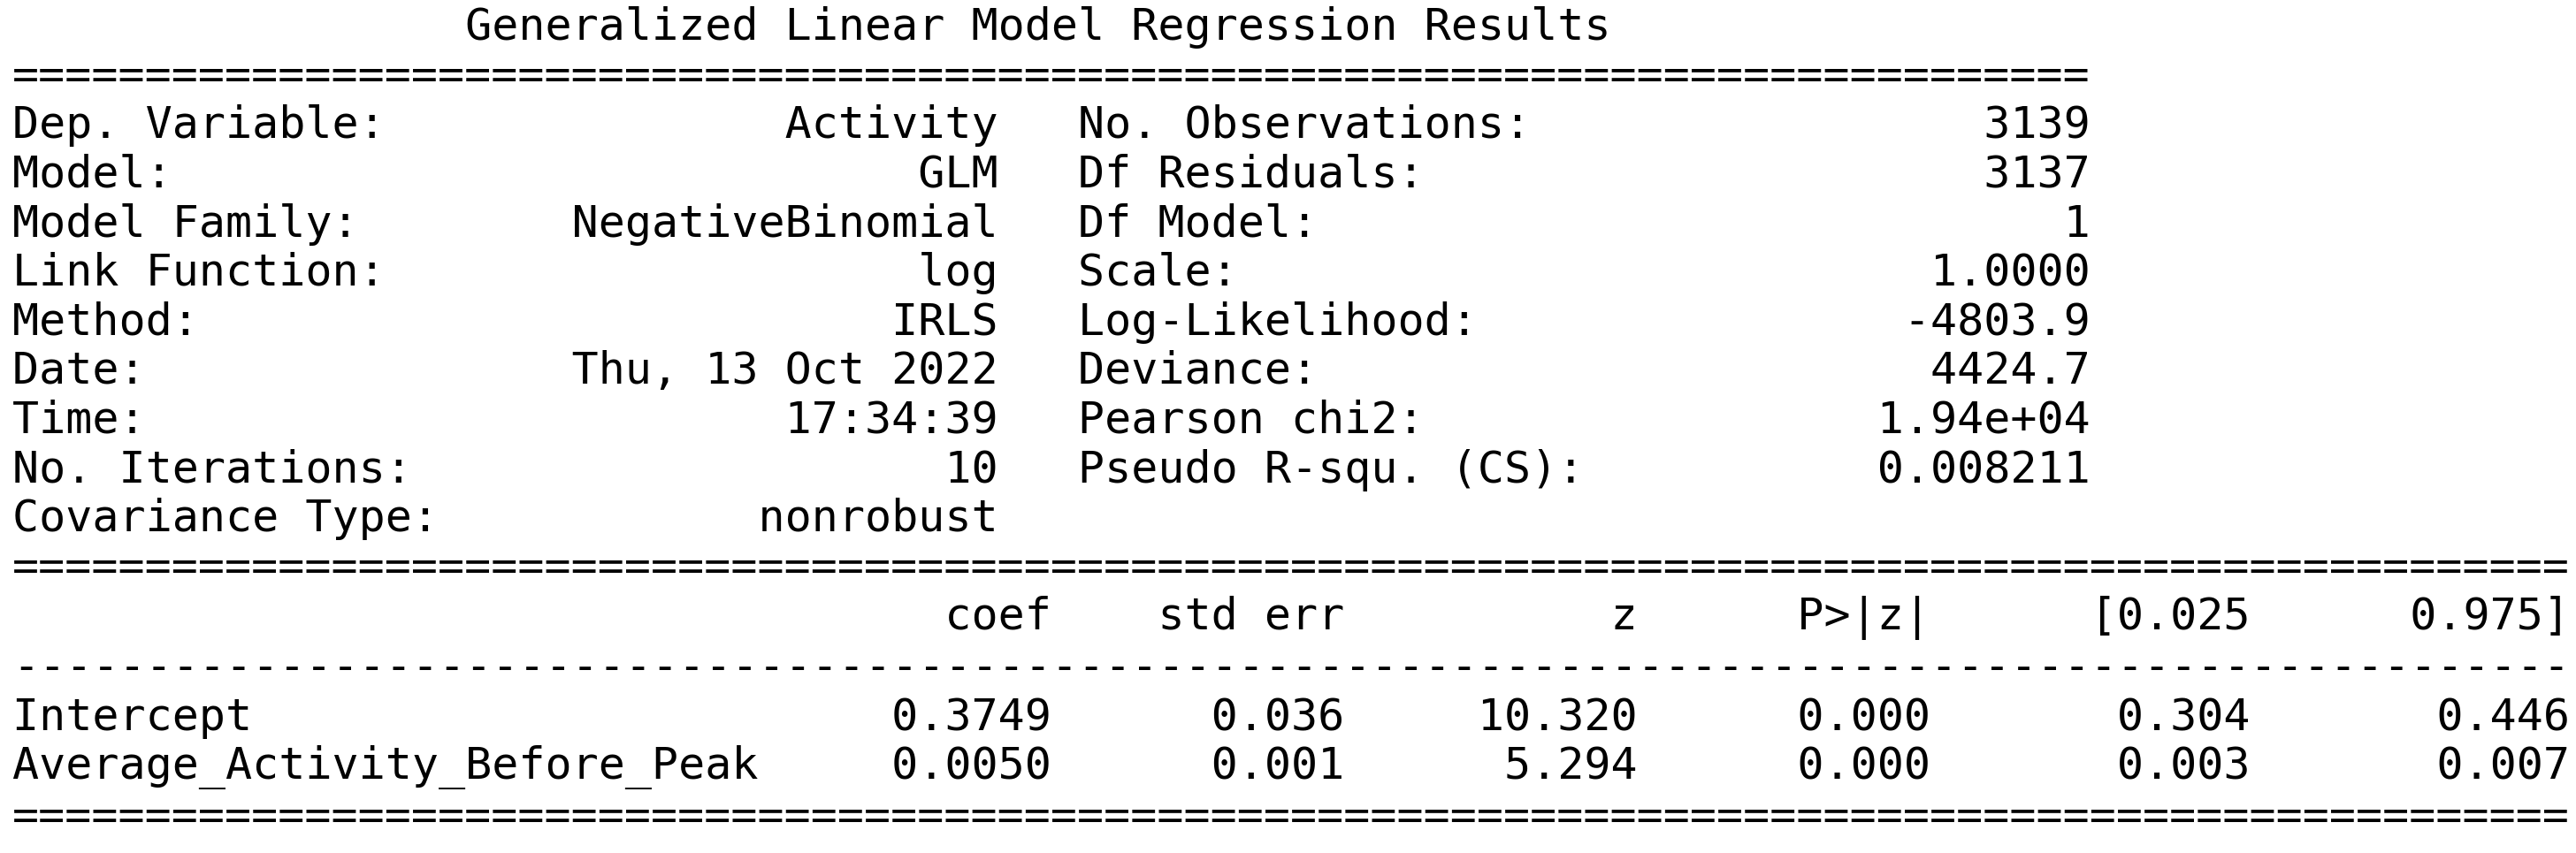

In [24]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(best_forward_model_act.summary()), {'fontsize': 50}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output.png')

In [ ]:
best_forward_model_interval = model_selection(
    df.drop(['interval','author_id','same_cluster_change','act_post_peak','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'interval_minutes',
    forward=True
)

best_backward_model_interval = model_selection(
    df.drop(['interval','author_id','same_cluster_change','act_post_peak','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'interval_minutes',
    forward=False
)

In [ ]:
best_forward_model_interval.summary()


In [ ]:
best_forward_model_interval.summary()
write_to_latex(best_backward_model_interval.summary(), group_num, 'interval_minutes', forward=True)

best_backward_model_interval.summary()
write_to_latex(best_backward_model_interval.summary(), group_num, 'interval_minutes', forward=False)

## Research Question 2: Drilling Down

In [ ]:
df['ht'].value_counts()

In [ ]:
df[df['ht']=='yotambien']

In [ ]:
ht_select = 'niunamenos'

data = df.drop(['interval','author_id','interval_minutes','same_cluster_change', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1)

data = data[data['ht']==ht_select]

x = model_selection(
    data,
    'act_post_peak',
    forward=True
    # family = sm.families.family.Gaussian(),
)

data = df.drop(['interval','author_id','same_cluster_change','act_post_peak', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1)

data = data[data['ht']==ht_select]

y = model_selection(
    data,
    'interval_minutes',
    forward=True
)

data = df.drop(['interval','author_id','interval_minutes','act_post_peak', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1)

data = data[data['ht']==ht_select]

z = model_selection(
    data,
    'same_cluster_change',
    family=sm.families.family.Gaussian(),
    forward=True
)

In [ ]:
x.summary()

In [ ]:
y.summary()

In [ ]:
z.summary()

# Group 2: 

In [ ]:
group_num = 3
hashtag_split = True
ngram_range = '34'
min_user = 100

overwrite = True
read_in = True

df = read_in_data(group_num)

In [ ]:
df['ht'].value_counts()

In [ ]:
df.describe()


In [ ]:
scatter_vis(df, target = 'act_post_peak', group_num=group_num)

In [ ]:
scatter_vis(df, target = 'same_cluster_change', group_num=group_num)

In [ ]:
scatter_vis(df, target = 'interval_minutes', group_num=group_num)

In [ ]:
# foward selection for cluster change:
best_forward_model = model_selection(
    df.drop(['interval','author_id','act_post_peak','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak'], axis=1),
    'same_cluster_change',
    sm.families.family.Gaussian()
)

In [ ]:
best_forward_model.summary()

In [ ]:
# foward selection for cluster change:
best_backward_model = model_selection(
    df.drop(['interval','author_id','act_post_peak','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak'], axis=1),
    'same_cluster_change',
    sm.families.family.Gaussian(),
    forward=False
)

In [ ]:
best_backward_model.summary()

In [ ]:
# foward selection for act post peak:
best_forward_model_act = model_selection(
    df.drop(['interval','author_id','same_cluster_change','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'act_post_peak'
)

In [ ]:
best_forward_model_act.summary()

In [ ]:
# foward selection for act post peak:
best_backward_model_act = model_selection(
    df.drop(['interval','author_id','same_cluster_change','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'act_post_peak',
    forward=False
)

In [ ]:
best_backward_model_act.summary()

In [ ]:
best_forward_model_interval = model_selection(
    df.drop(['interval','author_id','same_cluster_change','act_post_peak','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'interval_minutes',
    forward=True
)

In [ ]:
best_forward_model_interval.summary()

In [ ]:
best_backward_model_interval = model_selection(
    df.drop(['interval','author_id','same_cluster_change','act_post_peak','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'interval_minutes',
    forward=False
)

In [ ]:
best_backward_model_interval.summary()

## Drilling Down: Analysis per hashtag

In [ ]:
df['ht'].value_counts()

In [ ]:
data = df.drop(['interval','author_id','interval_minutes','same_cluster_change', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1)

data = data[~data['lang_diff']]

x = model_selection(
    data,
    'act_post_peak',
    forward=True
    # family = sm.families.family.Gaussian(),
)

In [ ]:
x.summary()

In [ ]:
df[df['ht']=='ятоже']

# Group 3: 2020-02-03 to 2020-03-16

In [ ]:
group_num = 3
hashtag_split = True
ngram_range = '34'
min_user = 100

overwrite = True
read_in = True

df = read_in_data(group_num)

In [ ]:
df

In [ ]:
df.describe()

In [ ]:
scatter_vis(df)

In [ ]:
# foward selection for cluster change:
best_forward_model = model_selection(
    df.drop(['interval','author_id','act_post_peak','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak'], axis=1),
    'same_cluster_change',
    sm.families.family.Gaussian()
)

In [ ]:
best_forward_model.summary()

In [ ]:
# foward selection for cluster change:
best_backward_model = model_selection(
    df.drop(['interval','author_id','act_post_peak','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak'], axis=1),
    'same_cluster_change',
    sm.families.family.Gaussian(),
    forward=False
)

In [ ]:
best_backward_model.summary()

In [ ]:
# foward selection for act post peak:
best_forward_model_act = model_selection(
    df.drop(['interval','author_id','same_cluster_change','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'act_post_peak'
)

In [ ]:
best_forward_model_act.summary()

In [ ]:
# foward selection for act post peak:
best_backward_model_act = model_selection(
    df.drop(['interval','author_id','same_cluster_change','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'act_post_peak',
    forward=False
)

In [ ]:
best_backward_model_act.summary()

In [ ]:
best_forward_model_interval = model_selection(
    df.drop(['interval','author_id','same_cluster_change','act_post_peak','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'interval_minutes',
    forward=True
)

In [ ]:
best_forward_model_interval.summary()

In [ ]:
best_backward_model_interval = model_selection(
    df.drop(['interval','author_id','same_cluster_change','act_post_peak','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'interval_minutes',
    forward=False
)

In [ ]:
best_backward_model_interval.summary()